      image_id   split         sat_image_path               mask_path
0       100034  train3  train3/100034_sat.jpg  train3/100034_mask.png
1       100081  train3  train3/100081_sat.jpg  train3/100081_mask.png
2       100129  train3  train3/100129_sat.jpg  train3/100129_mask.png
3       100703  train3  train3/100703_sat.jpg  train3/100703_mask.png
4       100712  train3  train3/100712_sat.jpg  train3/100712_mask.png
...        ...     ...                    ...                     ...
6221    999431  train3  train3/999431_sat.jpg  train3/999431_mask.png
6222    999531  train3  train3/999531_sat.jpg  train3/999531_mask.png
6223    999667  train3  train3/999667_sat.jpg  train3/999667_mask.png
6224    999764  train3  train3/999764_sat.jpg  train3/999764_mask.png
6225     99995  train3   train3/99995_sat.jpg   train3/99995_mask.png

[6226 rows x 4 columns]


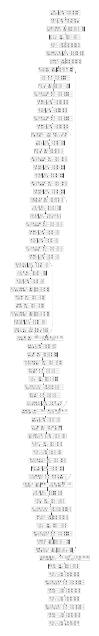

Epoch 1/5


2023-08-31 04:21:55.246737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


280/280 [==============================] - 89s 245ms/step - loss: 0.3706 - accuracy: 0.9051 - val_loss: 0.2410 - val_accuracy: 0.9569
Epoch 2/5
280/280 [==============================] - 52s 186ms/step - loss: 0.1815 - accuracy: 0.9577 - val_loss: 0.1571 - val_accuracy: 0.9569
Epoch 3/5
280/280 [==============================] - 52s 186ms/step - loss: 0.1446 - accuracy: 0.9580 - val_loss: 0.1677 - val_accuracy: 0.9505
Epoch 4/5
280/280 [==============================] - 52s 186ms/step - loss: 0.1216 - accuracy: 0.9606 - val_loss: 0.1265 - val_accuracy: 0.9586
Epoch 5/5
280/280 [==============================] - 52s 187ms/step - loss: 0.1053 - accuracy: 0.9637 - val_loss: 0.1054 - val_accuracy: 0.9633


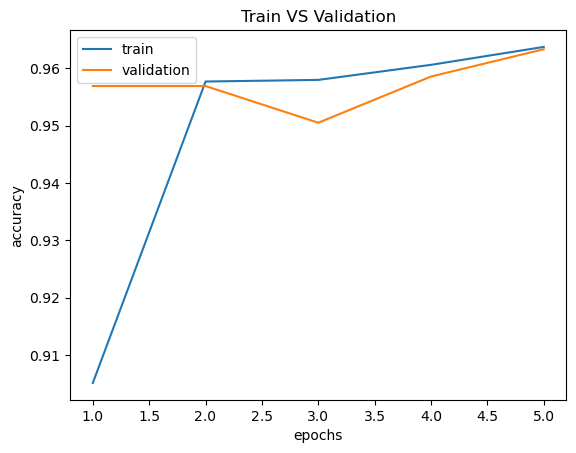

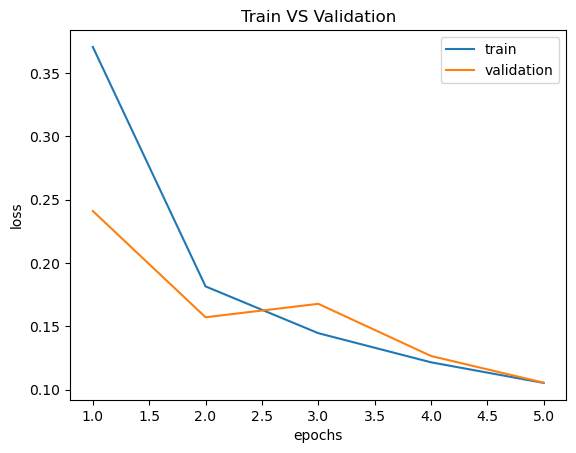

1/1 [==============================] - 1s 707ms/step


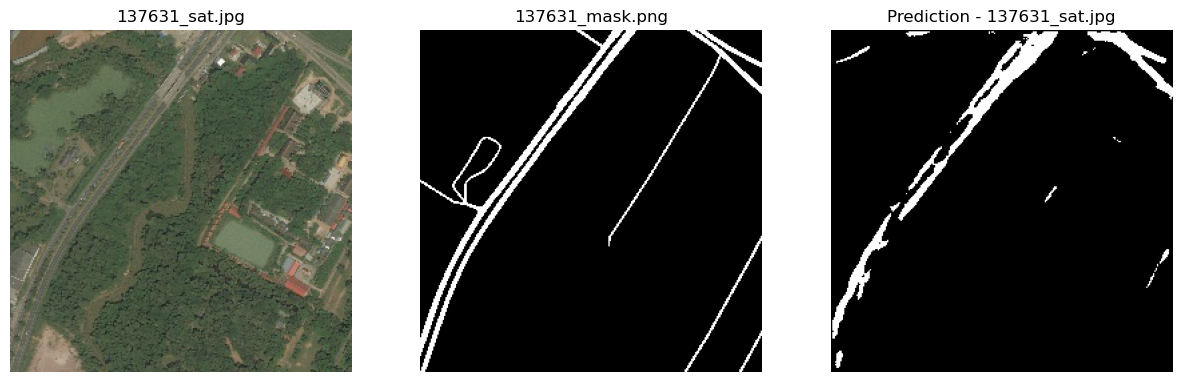

1/1 [==============================] - 0s 24ms/step


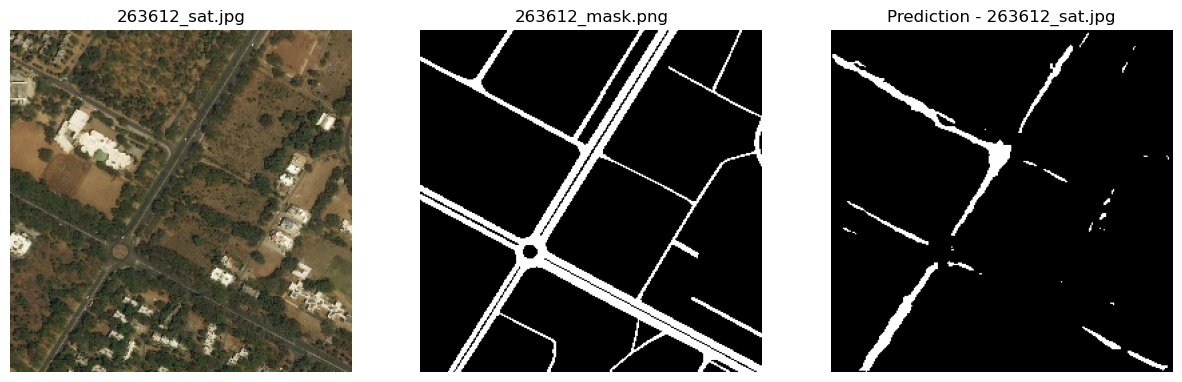

1/1 [==============================] - 0s 23ms/step


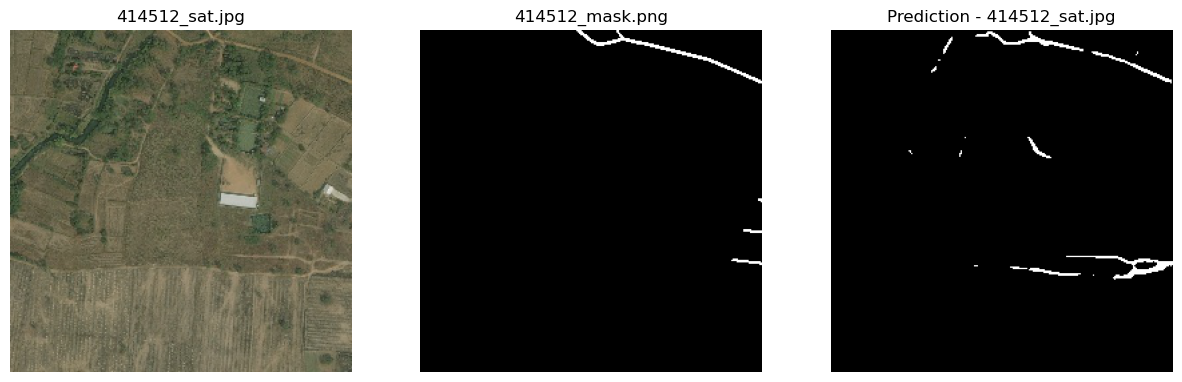

1/1 [==============================] - 0s 26ms/step


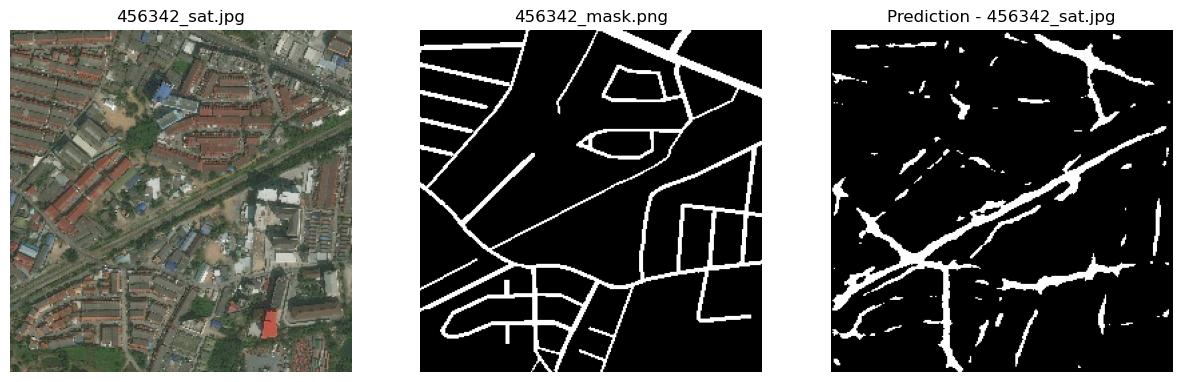

1/1 [==============================] - 0s 24ms/step


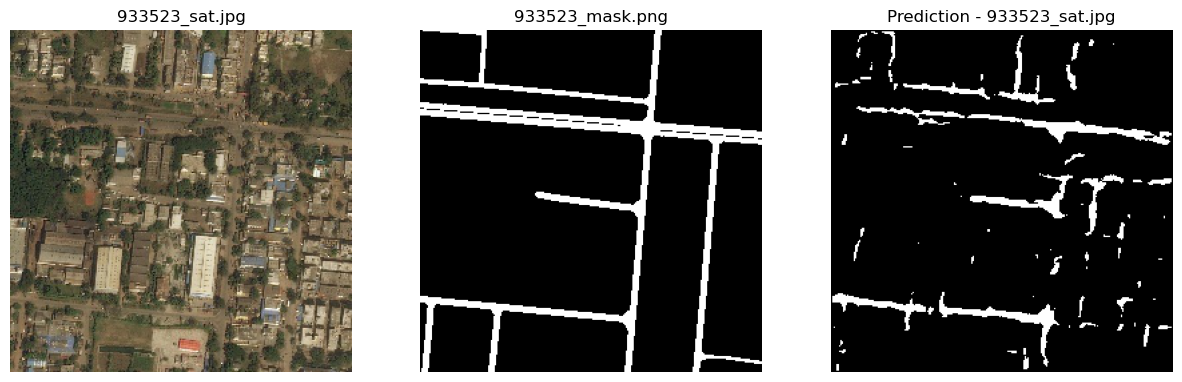

1/1 [==============================] - 0s 22ms/step


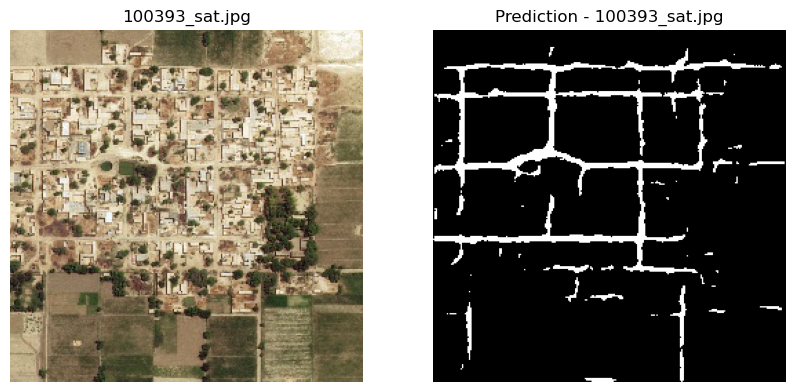

1/1 [==============================] - 0s 22ms/step


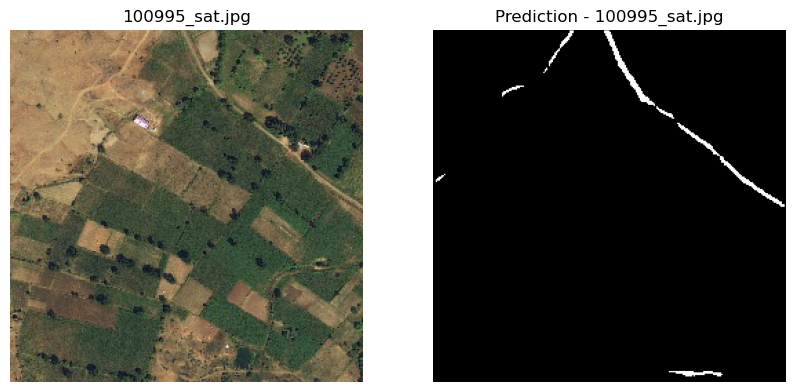

1/1 [==============================] - 0s 23ms/step


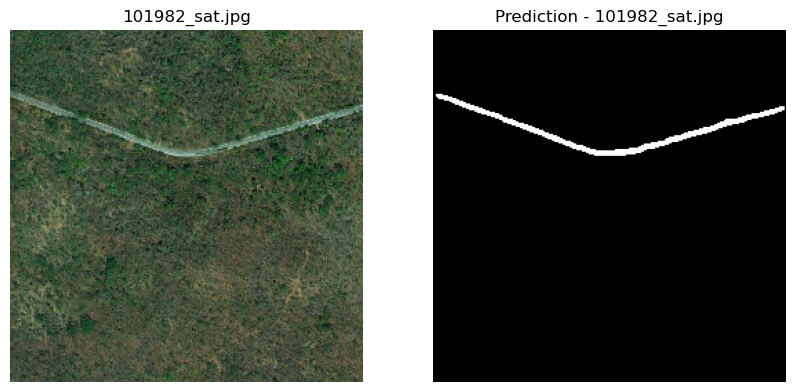

1/1 [==============================] - 0s 24ms/step


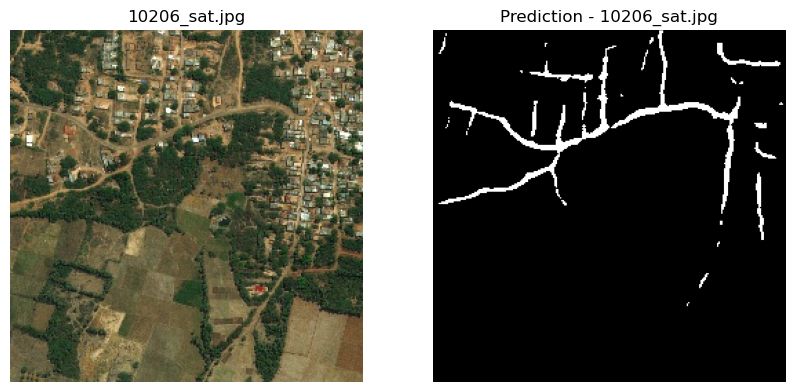

1/1 [==============================] - 0s 23ms/step


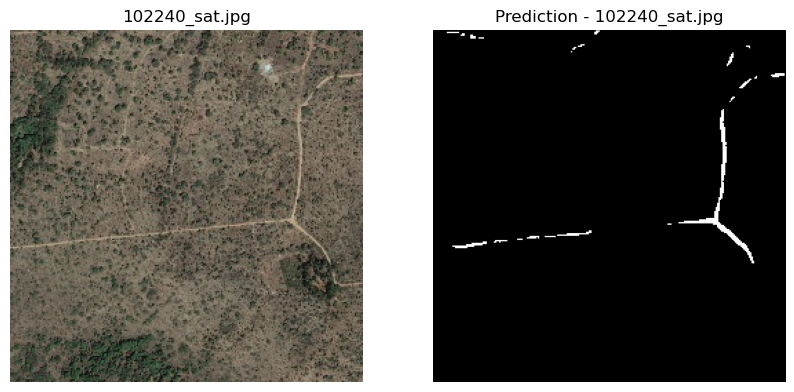

1/1 [==============================] - 0s 22ms/step


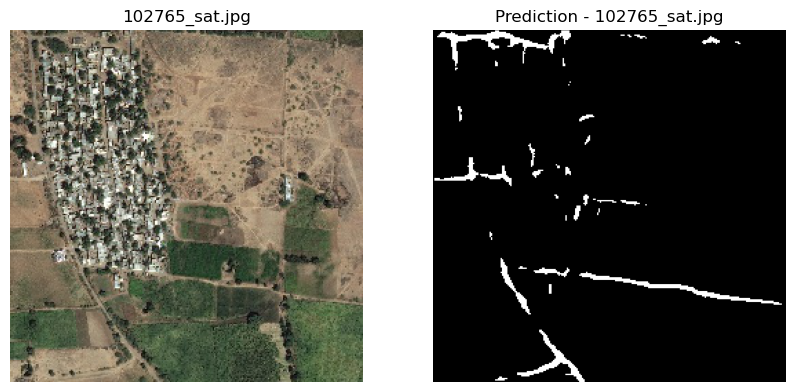

1/1 [==============================] - 0s 22ms/step


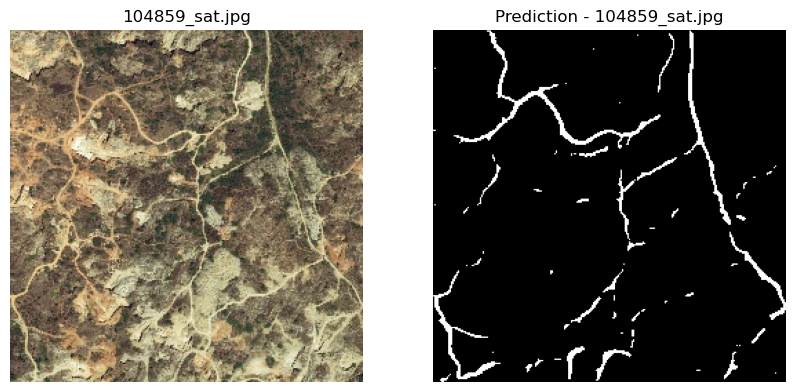

1/1 [==============================] - 0s 22ms/step


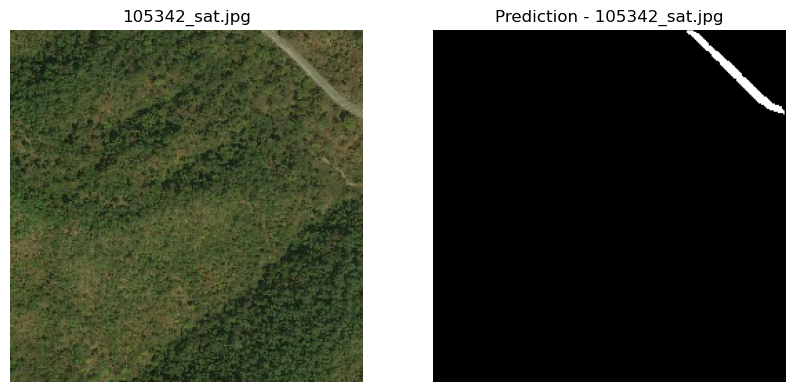

1/1 [==============================] - 0s 23ms/step


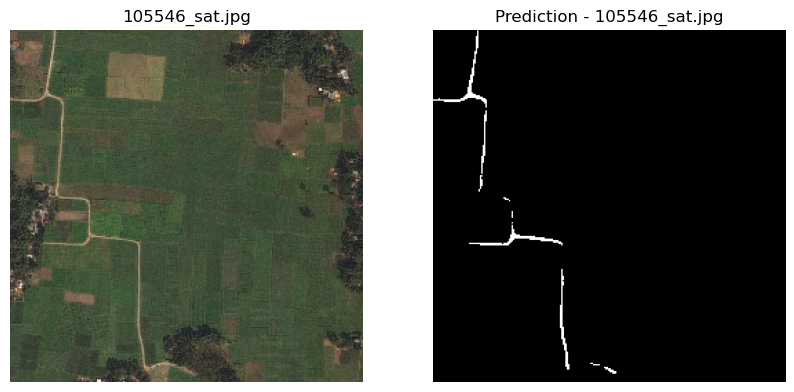

1/1 [==============================] - 0s 22ms/step


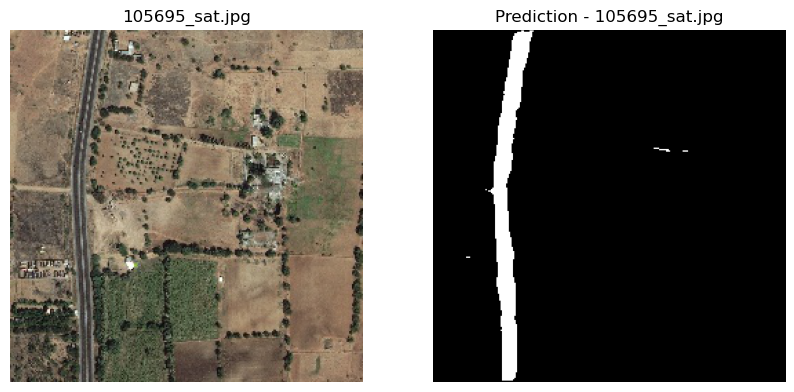

In [ ]:
import os
#import patoolib
import pandas as pd
import cv2 as cv
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    BatchNormalization,
    Dropout,
    Activation,
    Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint
)




project_path ='/kaggle/working/'

file_path = '/kaggle/input/deepglobe2/Deepglobe2/metadata.csv'
df = pd.read_csv(filepath_or_buffer=file_path)

train_data = df[df['split'] == 'train3']
valid_data = df[df['split'] == 'valid2']
test_data = df[df['split'] == 'test2']

print(train_data)


class Dataset:
    def __init__(self, df):
        self.df = df

        # paths of images
        self.sat_images = self.df['sat_image_path'].to_list()
        # paths of masked images
        self.masks_fps = self.df['mask_path'].to_list()

    def __getitem__(self, i):
        # read image directly into RGB format
        image = plt.imread('/kaggle/input/deepglobe2/Deepglobe2/' + self.sat_images[i])
        # read image mask
        image_mask = plt.imread('/kaggle/input/deepglobe2/Deepglobe2/' + self.masks_fps[i])
        image_mask = image_mask[:, :, 0]

        return image, image_mask

    def __len__(self):
        return len(self.df)


class DataLoder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size

        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


class UNET:
    # convolution block
    def _convolve(self, input_, filters):
        x = Conv2D(filters=filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(filters=filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        return x

    # up-sampling and convolotion block
    def _convolve_by_upsampling(self, input_, skip_connector, filters, rate):
        x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_)
        x = concatenate([x, skip_connector])
        x = Dropout(rate)(x)
        x = self._convolve(input_=x, filters=filters)
        return x

    # UNET main model
    def unet_main(self, input_, filters=16, rate=0.05):
        # left encoder Path
        c1 = self._convolve(input_=input_, filters=filters)
        p1 = MaxPooling2D(pool_size=(2, 2))(c1)
        p1 = Dropout(rate)(p1)

        c2 = self._convolve(input_=p1, filters=filters * 2)
        p2 = MaxPooling2D(pool_size=(2, 2))(c2)
        p2 = Dropout(rate)(p2)

        c3 = self._convolve(input_=p2, filters=filters * 4)
        p3 = MaxPooling2D(pool_size=(2, 2))(c3)
        p3 = Dropout(rate)(p3)

        c4 = self._convolve(input_=p3, filters=filters * 8)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)
        p4 = Dropout(rate)(p4)

        # middle bridge
        c5 = self._convolve(input_=p4, filters=filters * 16)

        # right decoder path
        c6 = self._convolve_by_upsampling(input_=c5, skip_connector=c4, filters=filters * 8, rate=rate)
        c7 = self._convolve_by_upsampling(input_=c6, skip_connector=c3, filters=filters * 4, rate=rate)
        c8 = self._convolve_by_upsampling(input_=c7, skip_connector=c2, filters=filters * 2, rate=rate)
        c9 = self._convolve_by_upsampling(input_=c8, skip_connector=c1, filters=filters * 1, rate=rate)

        output_ = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(c9)

        model = Model(inputs=[input_], outputs=[output_])

        return model


class Modeling:
    def __init__(self, train_data):
        self.train_data = train_data

    def _get_model(self):
        u = UNET()
        inputs = Input(shape=(256, 256, 3))
        model = u.unet_main(input_=inputs)
        return model

    def train_model(self, batch_size=20, model_name='unet_scratchtwo', epochs=5, show_performance=True):
        # since the original validation data does not have masks
        # i am considering `1%` of `train_data` as the `custom_validation`
        # in order to keep track of the model's performance
        self.custom_train, self.custom_valid = train_test_split(self.train_data, test_size=0.1, random_state=42)

        train_dataset = Dataset(df=self.custom_train)
        valid_dataset = Dataset(df=self.custom_valid)

        train_dataloader = DataLoder(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dataloader = DataLoder(valid_dataset, batch_size=batch_size, shuffle=True)

        model = self._get_model()
        # callbacks
        model_path = project_path + '{}.h5'.format(model_name)
        model_save_callback = ModelCheckpoint(
            filepath=model_path,
            save_weights_only=True,
            save_best_only=True,
            mode='max',
            monitor='val_accuracy'
        )
        callbacks = [model_save_callback]

        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
        #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
        # Plot the model
        fig = plt.figure(figsize=(10, 8))
        plot_model(model, to_file='model.png', show_shapes=True, dpi=300)
        plt.imshow(plt.imread('model.png'))
        plt.axis('off')
        plt.show()
        if not os.path.isfile(path=model_path):
            tracker = model.fit(
                x=train_dataloader,
                steps_per_epoch=len(train_dataloader),
                epochs=epochs,
                validation_data=valid_dataloader,
                callbacks=callbacks
            )
            model.load_weights(model_path)

            if show_performance:
                self._plot_performance(tracker=tracker, epochs=len(tracker.history['accuracy']))

        else:
            print('Model is already trained and is present in directory.')
            model.load_weights(model_path)

        return model

    def _plot_xy(self, x, y1, y2, yl, xl='epochs'):
        plt.plot(x, y1, label='train')
        plt.plot(x, y2, label='validation')
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title('Train VS Validation')
        plt.legend()
        plt.show()
        return None

    def _plot_performance(self, tracker, epochs):
        x = list(range(1, epochs + 1))

        train_iou = tracker.history['accuracy']
        valid_iou = tracker.history['val_accuracy']

        train_loss = tracker.history['loss']
        valid_loss = tracker.history['val_loss']

        self._plot_xy(x=x, y1=train_iou, y2=valid_iou, yl='accuracy')
        self._plot_xy(x=x, y1=train_loss, y2=valid_loss, yl='loss')

        return None

    def plot_custom_valid_performance(self, model, n=5):
        vdata = self.custom_valid.head(n)

        # paths of images
        images_fps = vdata['sat_image_path'].to_list()
        # paths of masked images
        masks_fps = vdata['mask_path'].to_list()

        for oimg, mimg in zip(images_fps, masks_fps):
            # original image
            simage = plt.imread('/kaggle/input/deepglobe2/Deepglobe2/' + oimg)

            # mask image
            mimage = plt.imread('/kaggle/input/deepglobe2/Deepglobe2/' + mimg)
            mimage = mimage[:, :, 0]

            # prediction
            predicted_image = model.predict(simage[np.newaxis, :, :, :])
            predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])
            # automatic threshold identification
            pmask_thresh = threshold_otsu(predicted_mask)
            # binarizing the mask
            th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255,
                                              type=cv.THRESH_BINARY)

            # titles
            image_title = oimg.split('/')[-1]
            mask_title = mimg.split('/')[-1]

            # plotting figure
            plt.figure(figsize=(15, 6))

            plt.subplot(131)
            plt.axis("off")
            plt.title(image_title)
            plt.imshow(simage)

            plt.subplot(132)
            plt.axis("off")
            plt.title(mask_title)
            plt.imshow(mimage, cmap='gray')

            plt.subplot(133)
            plt.axis("off")
            plt.title("Prediction - {}".format(image_title))
            plt.imshow(predicted_mask, cmap='gray')

            plt.show()

        return None

    def extract_road_path(self, x, model, n=10):
        x_ = x.head(n)

        # paths of images
        images_fps = x_['sat_image_path'].to_list()
        # paths of masked images
        masks_fps = x_['mask_path'].to_list()

        for oimg, mimg in zip(images_fps, masks_fps):
            # original image
            simage = plt.imread('/kaggle/input/deepglobe2/Deepglobe2/' + oimg)

            # prediction
            predicted_image = model.predict(simage[np.newaxis, :, :, :])
            predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])
            # automatic threshold identification
            pmask_thresh = threshold_otsu(predicted_mask)
            # binarizing the mask
            th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255,
                                              type=cv.THRESH_BINARY)
            image_title = oimg.split('/')[-1]

            plt.figure(figsize=(10, 6))

            plt.subplot(121)
            plt.axis("off")
            plt.title(image_title)
            plt.imshow(simage)

            plt.subplot(122)
            plt.axis("off")
            plt.title("Prediction - {}".format(image_title))
            plt.imshow(predicted_mask, cmap='gray')

            plt.show()

        return None

m = Modeling(train_data=train_data)

model = m.train_model()

m.plot_custom_valid_performance(model=model)

m.extract_road_path(x=test_data, model=model)